In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set consistent, attractive styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 14
})

print("Libraries imported successfully!")

Libraries imported successfully!


In [25]:
df = pd.read_csv("V:/Projects/vihaanraut_compute/ML_Tasks/ufc-fighters-statistics.csv")
print("Loaded:", df.shape)

# drop duplicates early
duplicate_count = df.duplicated().sum()

df = df.drop_duplicates()
print(f"Dropped {duplicate_count} duplicate rows. New shape: {df.shape}")

df.info()

Loaded: (4111, 18)
Dropped 0 duplicate rows. New shape: (4111, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4111 entries, 0 to 4110
Data columns (total 18 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          4111 non-null   object 
 1   nickname                                      2257 non-null   object 
 2   wins                                          4111 non-null   int64  
 3   losses                                        4111 non-null   int64  
 4   draws                                         4111 non-null   int64  
 5   height_cm                                     3813 non-null   float64
 6   weight_in_kg                                  4024 non-null   float64
 7   reach_in_cm                                   2184 non-null   float64
 8   stance                                        3288 non-null   object 
 

In [26]:
# Define reusable functions and column selectors
def get_column_types(dataframe):
    return {
        'object_cols': dataframe.select_dtypes(include='object').columns,
        'numerical_cols': dataframe.select_dtypes(include=['number']).columns
    }

def create_subplot_grid(n_items, max_cols=4):
    n_cols = min(max_cols, n_items)
    n_rows = (n_items + n_cols - 1) // n_cols
    return n_rows, n_cols

def plot_categorical_distributions(dataframe, cols, title_suffix="", figsize_multiplier=3):
    n_rows, n_cols = create_subplot_grid(len(cols), 4)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * figsize_multiplier))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    colors = sns.color_palette("Set2", len(cols))

    for i, col in enumerate(cols):
        counts = dataframe[col].value_counts(dropna=False)
        counts.plot(kind='bar', ax=axes[i], color=colors[i], alpha=0.8)
        axes[i].set_title(f'{col.title()}{title_suffix}', fontsize=12, pad=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Count', fontsize=10)
        axes[i].tick_params(axis='x', rotation=45, labelsize=9)

        # Add count labels on bars
        for j, v in enumerate(counts.values):
            axes[i].text(j, v + max(counts.values) * 0.01, str(v),
                        ha='center', va='bottom', fontsize=8)

    # Remove extra subplots
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    return fig, axes

def plot_numerical_distributions(dataframe, cols, title_suffix="", show_missing=True):
    n_rows, n_cols = create_subplot_grid(len(cols), 4)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    axes = axes.flatten()

    colors = sns.color_palette("plasma", len(cols))

    for i, col in enumerate(cols):
        ax = axes[i]

        # Create histogram
        dataframe[col].hist(bins=20, ax=ax, alpha=0.7, color=colors[i],
                           edgecolor='black', linewidth=0.5)

        # Add statistics
        col_mean = dataframe[col].mean()
        col_median = dataframe[col].median()
        col_missing = dataframe[col].isnull().sum()

        ax.axvline(col_mean, color='red', linestyle='--', alpha=0.8,
                  label=f'Mean: {col_mean:.1f}')
        ax.axvline(col_median, color='blue', linestyle='--', alpha=0.8,
                  label=f'Median: {col_median:.1f}')

        ax.set_title(f'{col}{title_suffix}', fontsize=11, pad=10)
        ax.set_xlabel('')
        ax.set_ylabel('Frequency', fontsize=10)
        ax.legend(fontsize=8, loc='upper right')

        # Add missing count annotation if requested
        if show_missing and col_missing > 0:
            ax.text(0.02, 0.98, f'Missing: {col_missing}', transform=ax.transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7),
                    fontsize=8)
        elif not show_missing:
            ax.text(0.02, 0.98, f'Complete: {len(dataframe) - col_missing}/{len(dataframe)}',
                    transform=ax.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
                    fontsize=8)

    # Remove extra subplots
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    return fig, axes

def plot_boxplots_for_outliers(dataframe, cols, title_suffix=""):
    """Reusable function for boxplot visualization to detect outliers"""
    n_rows, n_cols = create_subplot_grid(len(cols), 4)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    axes = axes.flatten()

    colors = sns.color_palette("coolwarm", len(cols))

    for i, col in enumerate(cols):
        ax = axes[i]

        # Create styled boxplot
        bp = ax.boxplot(dataframe[col].dropna(), patch_artist=True,
                       boxprops=dict(facecolor=colors[i], alpha=0.7),
                       medianprops=dict(color='black', linewidth=2),
                       flierprops=dict(marker='o', markerfacecolor='red', alpha=0.6, markersize=4))

        # Calculate outlier statistics
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_count = ((dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)).sum()

        # Add outlier count annotation
        ax.text(0.02, 0.98, f'Outliers: {outliers_count}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                fontsize=9)

        ax.set_title(f'{col}{title_suffix}', fontsize=11, pad=10)
        ax.set_ylabel('Value', fontsize=10)
        ax.grid(True, alpha=0.3)

    # Remove extra subplots
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    return fig, axes

def cap_outliers_iqr(dataframe, columns, multiplier=1.5):
    """
    Winsorize (clip) outliers using the IQR method.

    Parameters:
    - dataframe: Input DataFrame
    - columns: List/Index of numeric columns to process
    - multiplier: IQR multiplier for outlier bounds (default 1.5)

    For each column:
    1. Compute Q1, Q3, IQR
    2. Compute lower = Q1 - multiplier*IQR; upper = Q3 + multiplier*IQR
    3. Count outliers before
    4. Clip values to [lower, upper]
    5. Count remaining outliers (should be zero or near-zero due to numeric precision)
    """
    df_capped = dataframe.copy()
    outlier_stats = {}

    for col in columns:
        if col in df_capped.columns:
            Q1 = df_capped[col].quantile(0.25)
            Q3 = df_capped[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR

            outliers_before = ((df_capped[col] < lower_bound) | (df_capped[col] > upper_bound)).sum()

            df_capped[col] = df_capped[col].clip(lower_bound, upper_bound)

            outliers_after = ((df_capped[col] < lower_bound) | (df_capped[col] > upper_bound)).sum()

            outlier_stats[col] = {
                'outliers_before': int(outliers_before),
                'outliers_after': int(outliers_after),
                'lower_bound': float(lower_bound),
                'upper_bound': float(upper_bound),
                'Q1': float(Q1),
                'Q3': float(Q3),
                'IQR': float(IQR)
            }

    return df_capped, outlier_stats

In [27]:
# Define column types once - this will be updated as data changes
column_info = get_column_types(df)
print(f"Dataset loaded with {len(column_info['object_cols'])} categorical and {len(column_info['numerical_cols'])} numerical columns")

Dataset loaded with 4 categorical and 14 numerical columns


In [28]:
print(f"\nCurrent  summary:")
print(f"Shape: {df.shape[0]} rows x {df.shape[1]} columns")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Categorical columns: {len(column_info['object_cols'])}")
print(f"Numerical columns: {len(column_info['numerical_cols'])}")


Current  summary:
Shape: 4111 rows x 18 columns
Missing values: 6124
Duplicate rows: 0
Categorical columns: 4
Numerical columns: 14


In [29]:
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,name,nickname,wins,losses,draws,height_cm,weight_in_kg,reach_in_cm,stance,date_of_birth,significant_strikes_landed_per_minute,significant_striking_accuracy,significant_strikes_absorbed_per_minute,significant_strike_defence,average_takedowns_landed_per_15_minutes,takedown_accuracy,takedown_defense,average_submissions_attempted_per_15_minutes
0,Robert Drysdale,NaN,7,0,0,190.50,92.99,NaN,Orthodox,1981-10-05,0.00,0.0,0.00,0.0,7.32,100.0,0.0,21.9
1,Daniel McWilliams,The Animal,15,37,0,185.42,83.91,NaN,NaN,NaN,3.36,77.0,0.00,0.0,0.00,0.0,100.0,21.6
2,Dan Molina,NaN,13,9,0,177.80,97.98,NaN,NaN,NaN,0.00,0.0,5.58,60.0,0.00,0.0,0.0,20.9
3,Paul Ruiz,NaN,7,4,0,167.64,61.23,NaN,NaN,NaN,1.40,33.0,1.40,75.0,0.00,0.0,100.0,20.9
4,Collin Huckbody,All In,8,2,0,190.50,83.91,193.04,Orthodox,1994-09-29,2.05,60.0,2.73,42.0,10.23,100.0,0.0,20.4


In [30]:
print("Basic statistics for numerical columns:")
df.describe()

Basic statistics for numerical columns:


,wins,losses,draws,height_cm,weight_in_kg,reach_in_cm,significant_strikes_landed_per_minute,significant_striking_accuracy,significant_strikes_absorbed_per_minute,significant_strike_defence,average_takedowns_landed_per_15_minutes,takedown_accuracy,takedown_defense,average_submissions_attempted_per_15_minutes
count,4111.000000,4111.000000,4111.000000,3813.000000,4024.000000,2184.000000,4111.000000,4111.000000,4111.000000,4111.000000,4111.000000,4111.000000,4111.000000,4111.000000
mean,12.366821,5.726344,0.264413,178.234325,77.395825,181.808874,2.437516,35.542447,3.145206,42.643639,1.250586,26.299927,38.958891,0.610095
std,9.374667,5.103768,0.822373,8.888050,17.982242,10.680804,1.990903,20.398502,2.848502,22.322427,1.935716,28.700980,34.426458,1.505924
min,0.000000,0.000000,0.000000,152.400000,47.630000,147.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,2.000000,0.000000,172.720000,65.770000,175.260000,0.830000,27.000000,1.550000,36.000000,0.000000,0.000000,0.000000,0.000000
50%,11.000000,5.000000,0.000000,177.800000,77.110000,182.880000,2.330000,40.000000,2.940000,50.000000,0.590000,22.000000,42.000000,0.000000
75%,17.000000,8.000000,0.000000,185.420000,83.910000,190.500000,3.600000,49.000000,4.230000,58.000000,1.940000,45.000000,66.000000,0.700000
max,253.000000,83.000000,11.000000,226.060000,349.270000,213.360000,17.650000,100.000000,52.500000,100.000000,32.140000,100.000000,100.000000,21.900000


In [31]:
print("Dataset information:")
print(f"Numerical columns: {len(df.select_dtypes(include=['number']).columns)}")
print(f"Text/Categorical columns: {len(df.select_dtypes(include=['object']).columns)}")
print(f"Target variable: G3 (Final grade)")

Dataset information:
Numerical columns: 14
Text/Categorical columns: 4
Target variable: G3 (Final grade)


Total missing values: 6124
Percentage missing: 8.28%


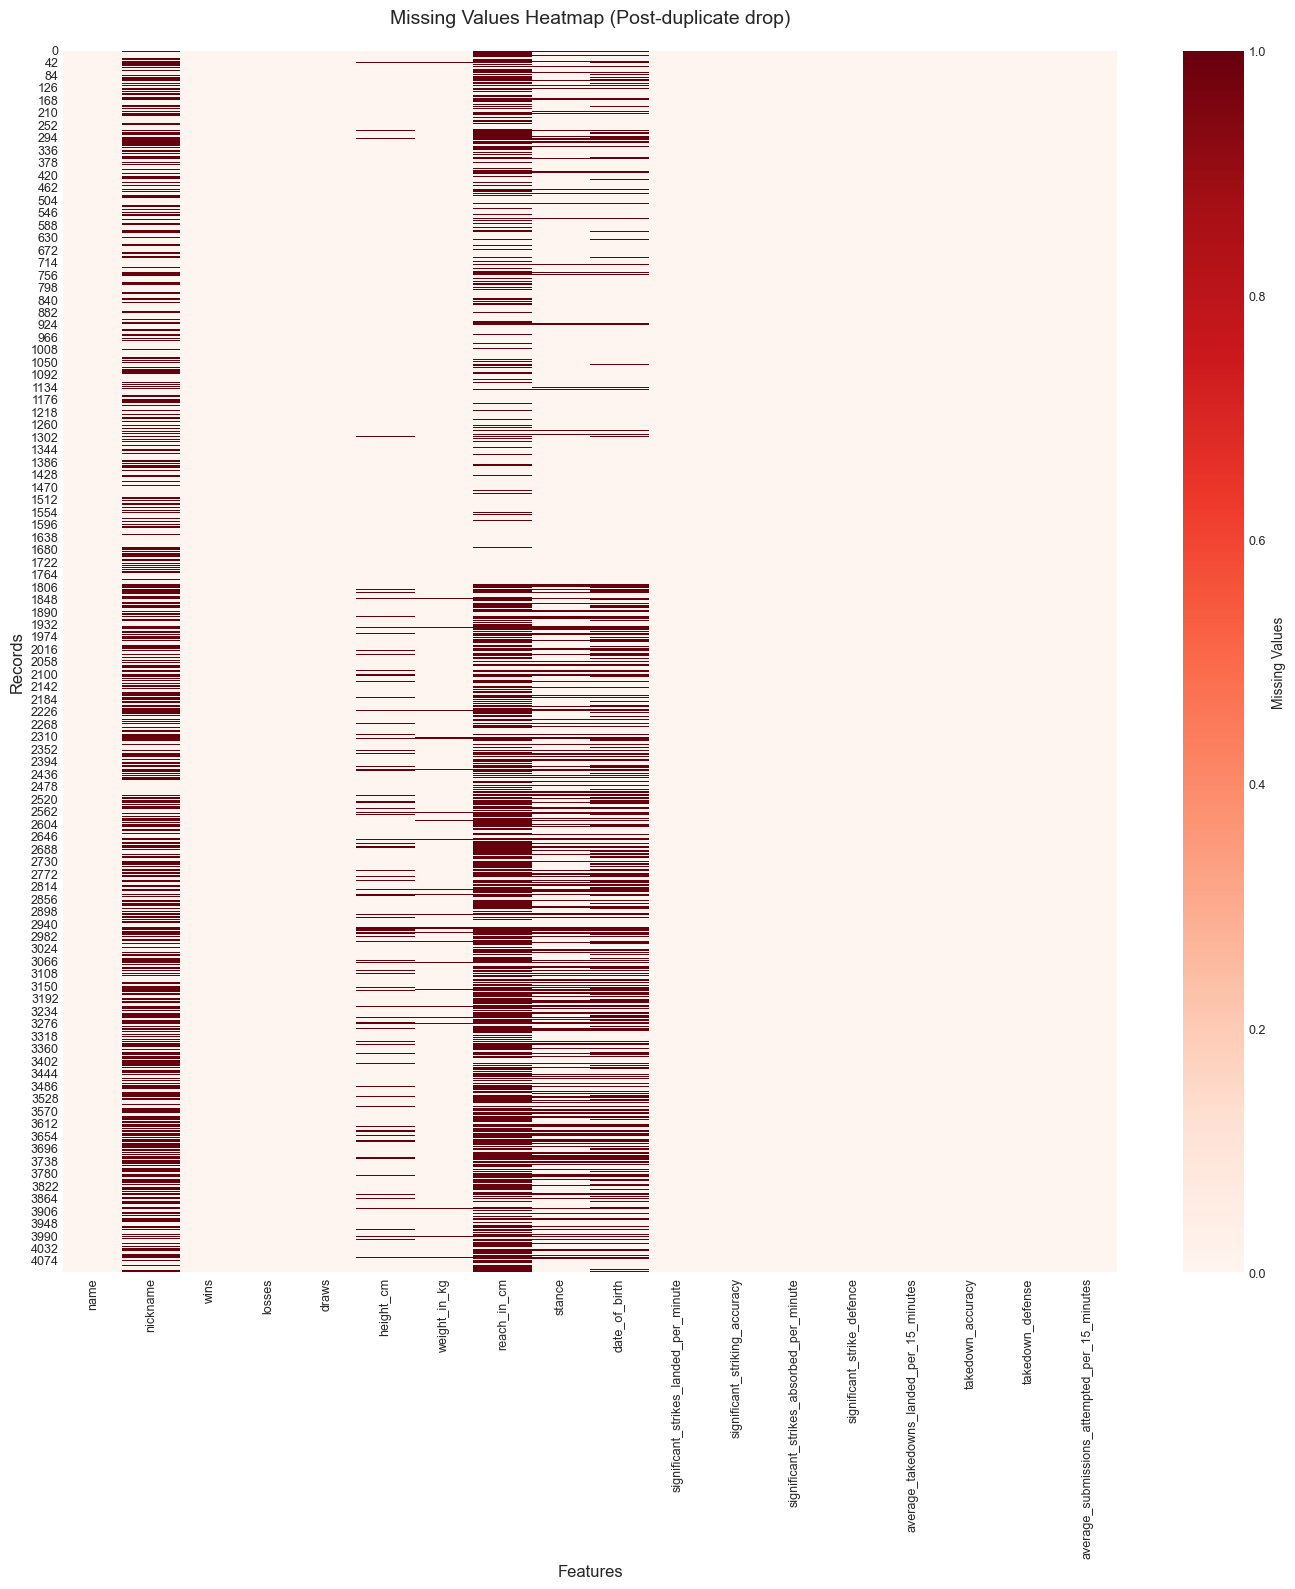

In [32]:
missing_stats = {
    'missing_values': df.isnull().sum(),
    'total_missing': df.isnull().sum().sum(),
    'total_cells': df.shape[0] * df.shape[1]
}

print(f"Total missing values: {missing_stats['total_missing']}")
print(f"Percentage missing: {(missing_stats['total_missing'] / missing_stats['total_cells']) * 100:.2f}%")

# clean, focused heatmap
fig, ax = plt.subplots(figsize=(14, 16))
sns.heatmap(df.isnull(), cbar=True, cmap='Reds',
           cbar_kws={'label': 'Missing Values'}, ax=ax)
ax.set_title('Missing Values Heatmap (Post-duplicate drop)', fontsize=14, pad=20)
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Records', fontsize=12)
plt.tight_layout()
plt.show()

In [33]:
# check for duplicates once
duplicate_count = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicate_count}")


Duplicate rows: 0


In [34]:
# analyze categorical columns (using predefined column_info)
print("Categorical column unique values:")
for col in column_info['object_cols']:
    unique_vals = df[col].value_counts(dropna=False).index.tolist()
    print(f"{col}: {unique_vals}")
    print()

Categorical column unique values:
name: ['Mike Davis', 'Michael McDonald', 'Bruno Silva', 'Jean Silva', 'Joey Gomez', 'Tony Johnson', 'Kenneth Seegrist', 'Will Kerr', 'Juan Puerta', 'Rodrigo Gripp de Sousa', 'Keith Mielke', 'Homer Moore', 'Neil Grove', 'Pauline Macias', 'Collin Huckbody', 'Raphael Butler', 'Bo Nickal', 'Ian Entwistle', 'Megumi Fujii', 'Gaston Reyno', 'Kenny Ento', 'AJ McKee', 'Westin Wilson', 'Philip Perez', 'Brandon Shuey', 'Dave Phillips', 'Johnny Sampaio', 'Dione Barbosa', 'Zach Reese', 'Daniel McWilliams', 'Justin Burlinson', 'Poppies Martinez', 'Josh Rafferty', 'Daniel Puder', 'Yukio Sakaguchi', 'Magomed Sultanakhmedov', 'Jeff Newton', 'Emiliano Sordi', 'Erik Apple', 'Fazlo Mulabitinovic', 'J.T Taylor', 'Adam Meredith', 'Klayton Mai', 'Ron Keslar', 'Bobby McAndrews', 'Ansar Chalangov', 'Jeremiah Constant', 'Paul Sass', 'Eddy Millis', 'James Lee', 'Mikhail Iloukhine', 'Kyle Jensen', 'Ilya Kotau', 'Trevor Harris', 'Jinnosuke Kashimura', 'Tom Erikson', 'Jason Black',

Outlier detection analysis using boxplots:


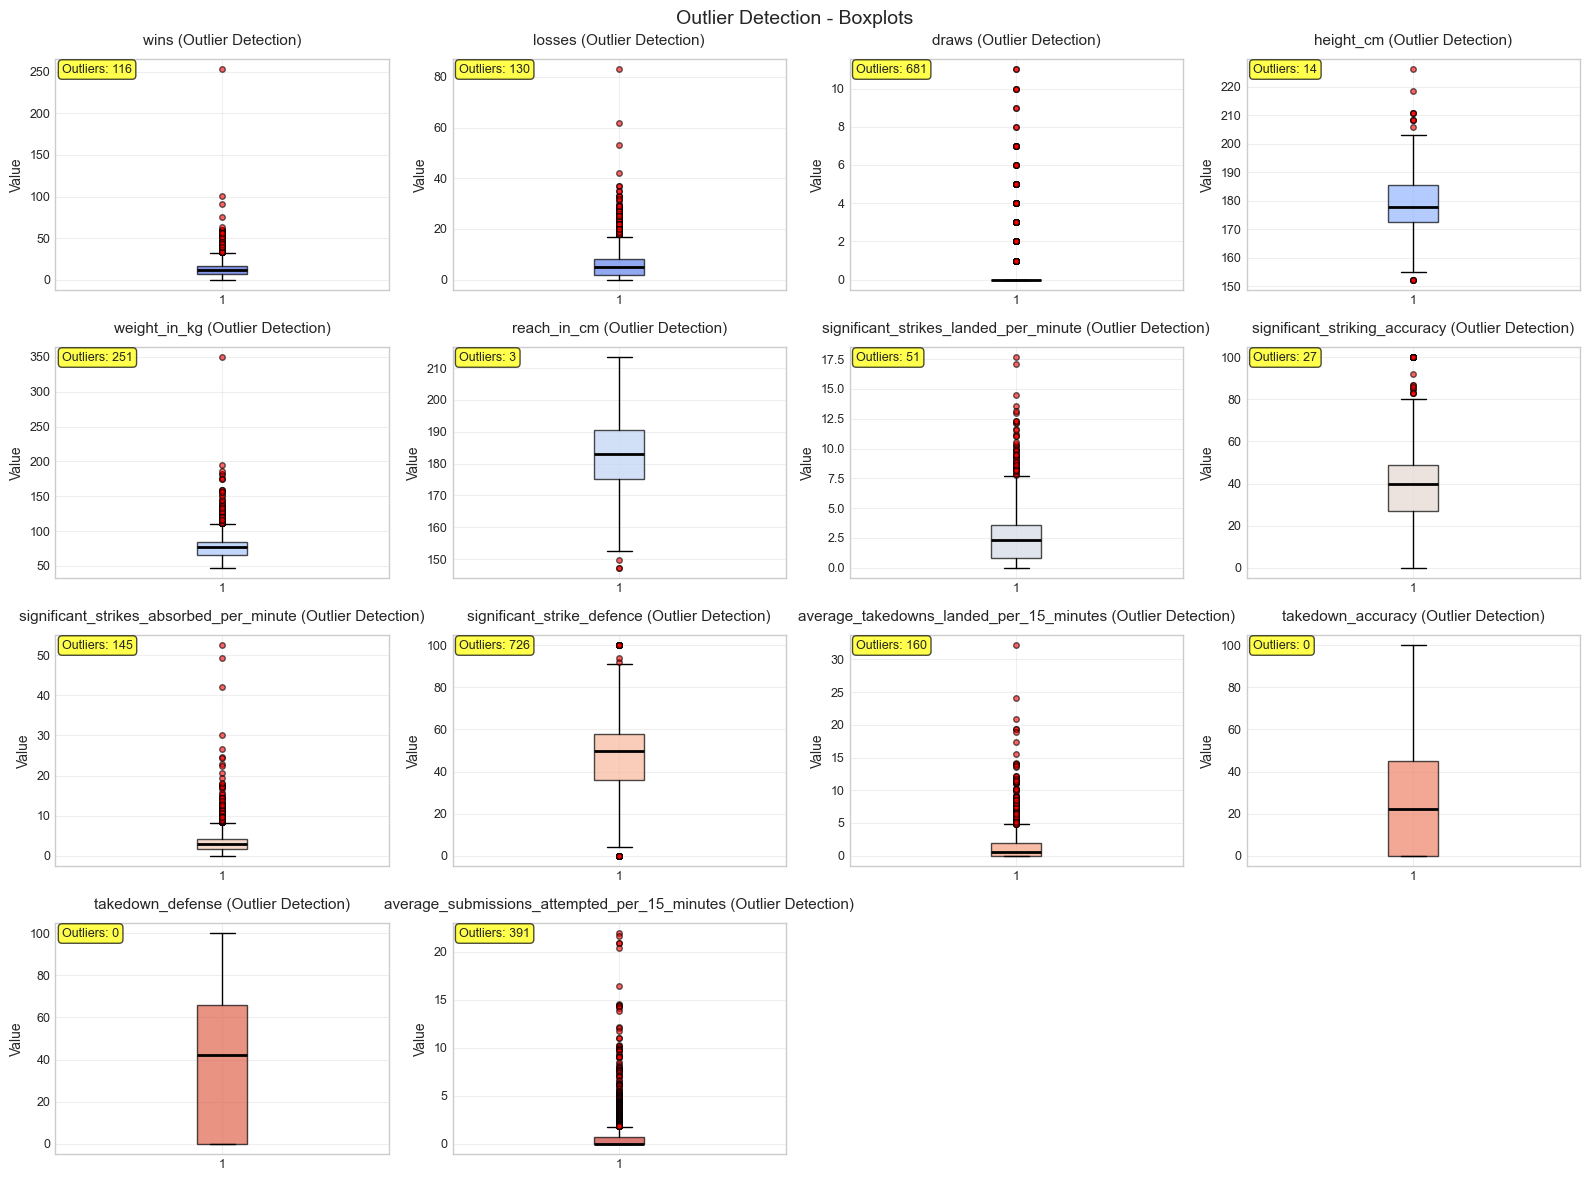

In [35]:
print("Outlier detection analysis using boxplots:")
fig, axes = plot_boxplots_for_outliers(df, column_info['numerical_cols'],
                                      title_suffix=" (Outlier Detection)")
plt.suptitle('Outlier Detection - Boxplots', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

In [36]:
# store original data for comparison
df_before_capping = df.copy()

# apply IQR-based winsorization (clipping) to numeric features except target
print("Applying outlier capping using IQR clipping (multiplier=2.5)...")
num_cols = column_info['numerical_cols'].drop('G3', errors='ignore')
df_capped, outlier_statistics = cap_outliers_iqr(df, num_cols, multiplier=2.5)

# display outlier statistics
total_outliers_capped = 0
print("Outlier analysis results:")
for col, stats in outlier_statistics.items():
    if stats['outliers_before'] > 0:
        print(f"{col}: {stats['outliers_before']} -> {stats['outliers_after']} after capping")
        total_outliers_capped += stats['outliers_before']

print(f"Total outliers processed: {total_outliers_capped}")
print(f"Percentage of cells affected: {(total_outliers_capped / (len(df) * len(num_cols))) * 100:.2f}%")

# update the main dataframe
df = df_capped.copy()

Applying outlier capping using IQR clipping (multiplier=2.5)...
Outlier analysis results:
wins: 29 -> 0 after capping
losses: 40 -> 0 after capping
draws: 681 -> 0 after capping
height_cm: 2 -> 0 after capping
weight_in_kg: 32 -> 0 after capping
significant_strikes_landed_per_minute: 16 -> 0 after capping
significant_strikes_absorbed_per_minute: 57 -> 0 after capping
average_takedowns_landed_per_15_minutes: 75 -> 0 after capping
average_submissions_attempted_per_15_minutes: 223 -> 0 after capping
Total outliers processed: 1155
Percentage of cells affected: 2.01%


Outliers after capping:


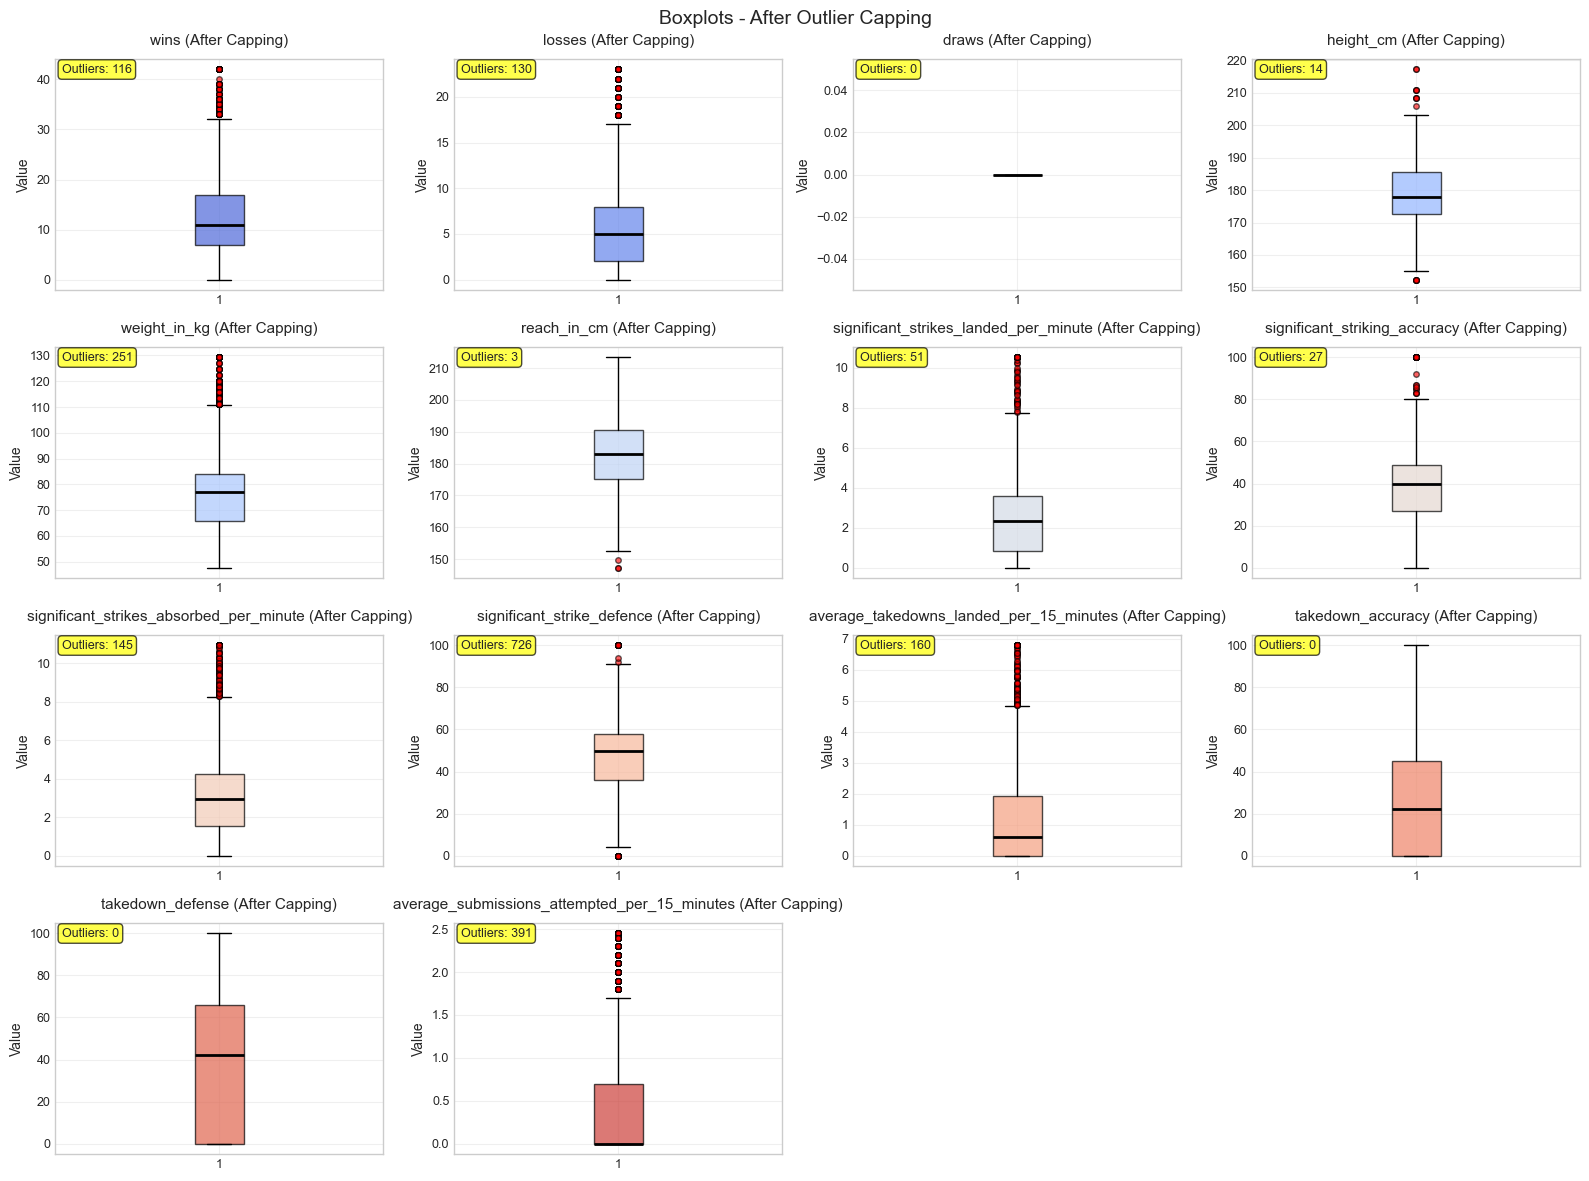

In [37]:
# visualize outliers after capping using boxplots
print("Outliers after capping:")
fig, axes = plot_boxplots_for_outliers(df, column_info['numerical_cols'],
                                      title_suffix=" (After Capping)")
plt.suptitle('Boxplots - After Outlier Capping', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

In [38]:

#fill the missing values in categorical columns
impute_logs = []
for col in column_info['object_cols']:
    # explicitly replace 'nan' strings with actual NaN values
    df[col] = df[col].replace('nan', np.nan)

    missing = int(df[col].isna().sum())
    if missing == 0:
        continue

    mode_vals = df[col].mode(dropna=True)
    if not mode_vals.empty:
        col_mode = mode_vals.iloc[0]
        df[col] = df[col].fillna(col_mode)
        impute_logs.append((col, missing, f'mode: {col_mode!r}'))
    else:
        df[col] = df[col].fillna('missing')
        impute_logs.append((col, missing, 'sentinel: "missing" (fallback)'))

if impute_logs:
    print("Categorical imputation completed for:")
    for name, cnt, how in impute_logs:
        print(f"- {name}: {cnt} via {how}")
else:
    print("No missing values found in categorical columns")

Categorical imputation completed for:
- nickname: 1854 via mode: 'The Beast'
- stance: 823 via mode: 'Orthodox'
- date_of_birth: 1135 via mode: '1987-01-21'


In [39]:
# verify
impute_logs = []
for col in column_info['object_cols']:
    # explicitly replace 'nan' strings with actual NaN values
    df[col] = df[col].replace('nan', np.nan)

    missing = int(df[col].isna().sum())
    if missing == 0:
        continue

    mode_vals = df[col].mode(dropna=True)
    if not mode_vals.empty:
        col_mode = mode_vals.iloc[0]
        df[col] = df[col].fillna(col_mode)
        impute_logs.append((col, missing, f'mode: {col_mode!r}'))
    else:
        df[col] = df[col].fillna('missing')
        impute_logs.append((col, missing, 'sentinel: "missing" (fallback)'))

if impute_logs:
    print("Categorical imputation completed for:")
    for name, cnt, how in impute_logs:
        print(f"- {name}: {cnt} via {how}")
else:
    print("No missing values found in categorical columns")

No missing values found in categorical columns


Distribution before Imputation:


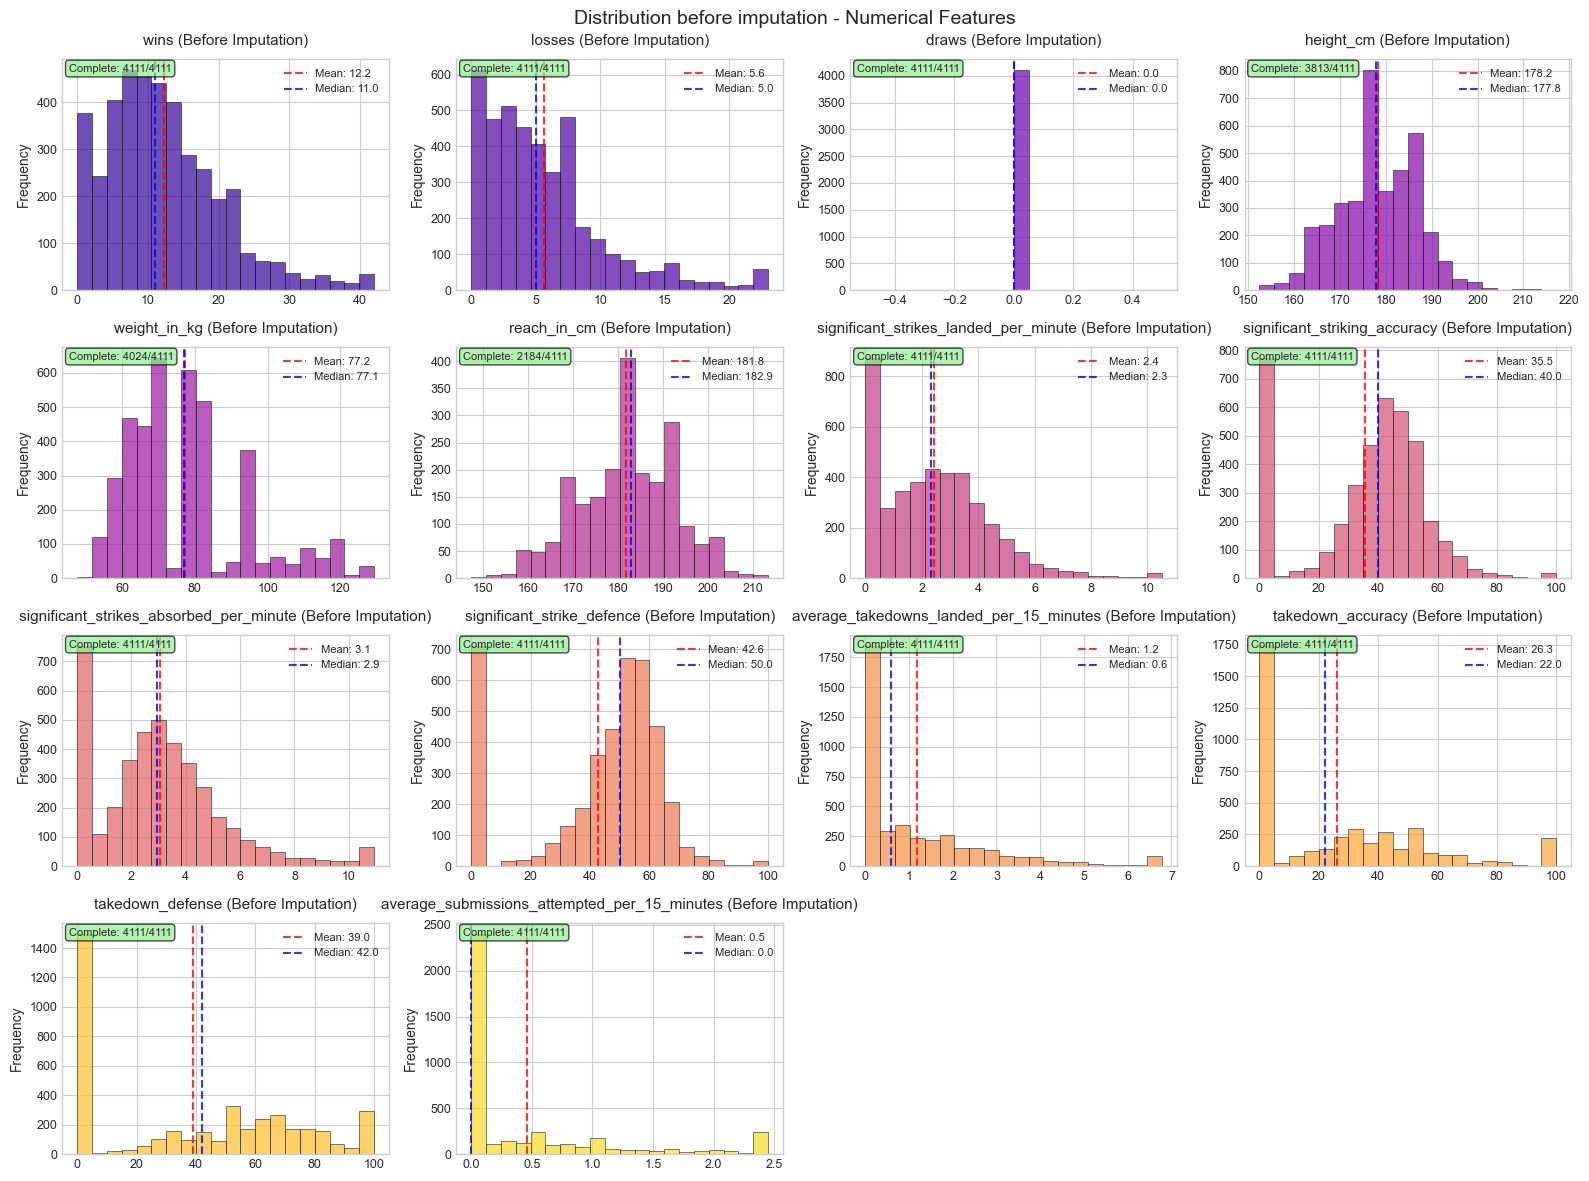

In [40]:
print("Distribution before Imputation:")

num_cols = column_info['numerical_cols'].drop('G3', errors='ignore')
fig, axes = plot_numerical_distributions(df, num_cols,
                                       title_suffix=" (Before Imputation)",
                                       show_missing=False)
plt.suptitle('Distribution before imputation - Numerical Features', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

In [41]:
total_imputed = sum(df[col].isnull().sum() for col in num_cols)
total_missing_numerical = df[num_cols].isnull().sum().sum()
print(f"Total values imputed: {total_imputed}")
print(f"Remaining missing numerical values: {total_missing_numerical}")

Total values imputed: 2312
Remaining missing numerical values: 2312


In [42]:

print("Numerical imputation:")

from pandas.api.types import is_integer_dtype

imputation_summary = []
num_cols = column_info['numerical_cols'].drop('G3', errors='ignore')
orig_dtypes = df[num_cols].dtypes

for col in num_cols:
    missing_count = df[col].isnull().sum()
    if missing_count == 0:
        continue

    skew = df[col].skew() if not pd.isna(df[col].skew()) else 0
    if abs(skew) > 1:
        value = df[col].median()
        method = "median (due to skewness)"
    else:
        value = df[col].mean()
        method = "mean"

    df[col] = df[col].fillna(value)
    if is_integer_dtype(orig_dtypes[col]):
        df[col] = df[col].round().astype('Int64')

    if col in {"G1", "G2"}:
        df[col] = df[col].clip(0, 20)
    if col == "absences":
        df[col] = df[col].clip(lower=0)

    imputation_summary.append({
        'column': col,
        'missing_count': int(missing_count),
        'method': method,
        'value': float(value)
    })
    print(f"{col}: Imputed {missing_count} missing values with {method}")




Numerical imputation:
height_cm: Imputed 298 missing values with mean
weight_in_kg: Imputed 87 missing values with mean
reach_in_cm: Imputed 1927 missing values with mean


Distribution after imputation:


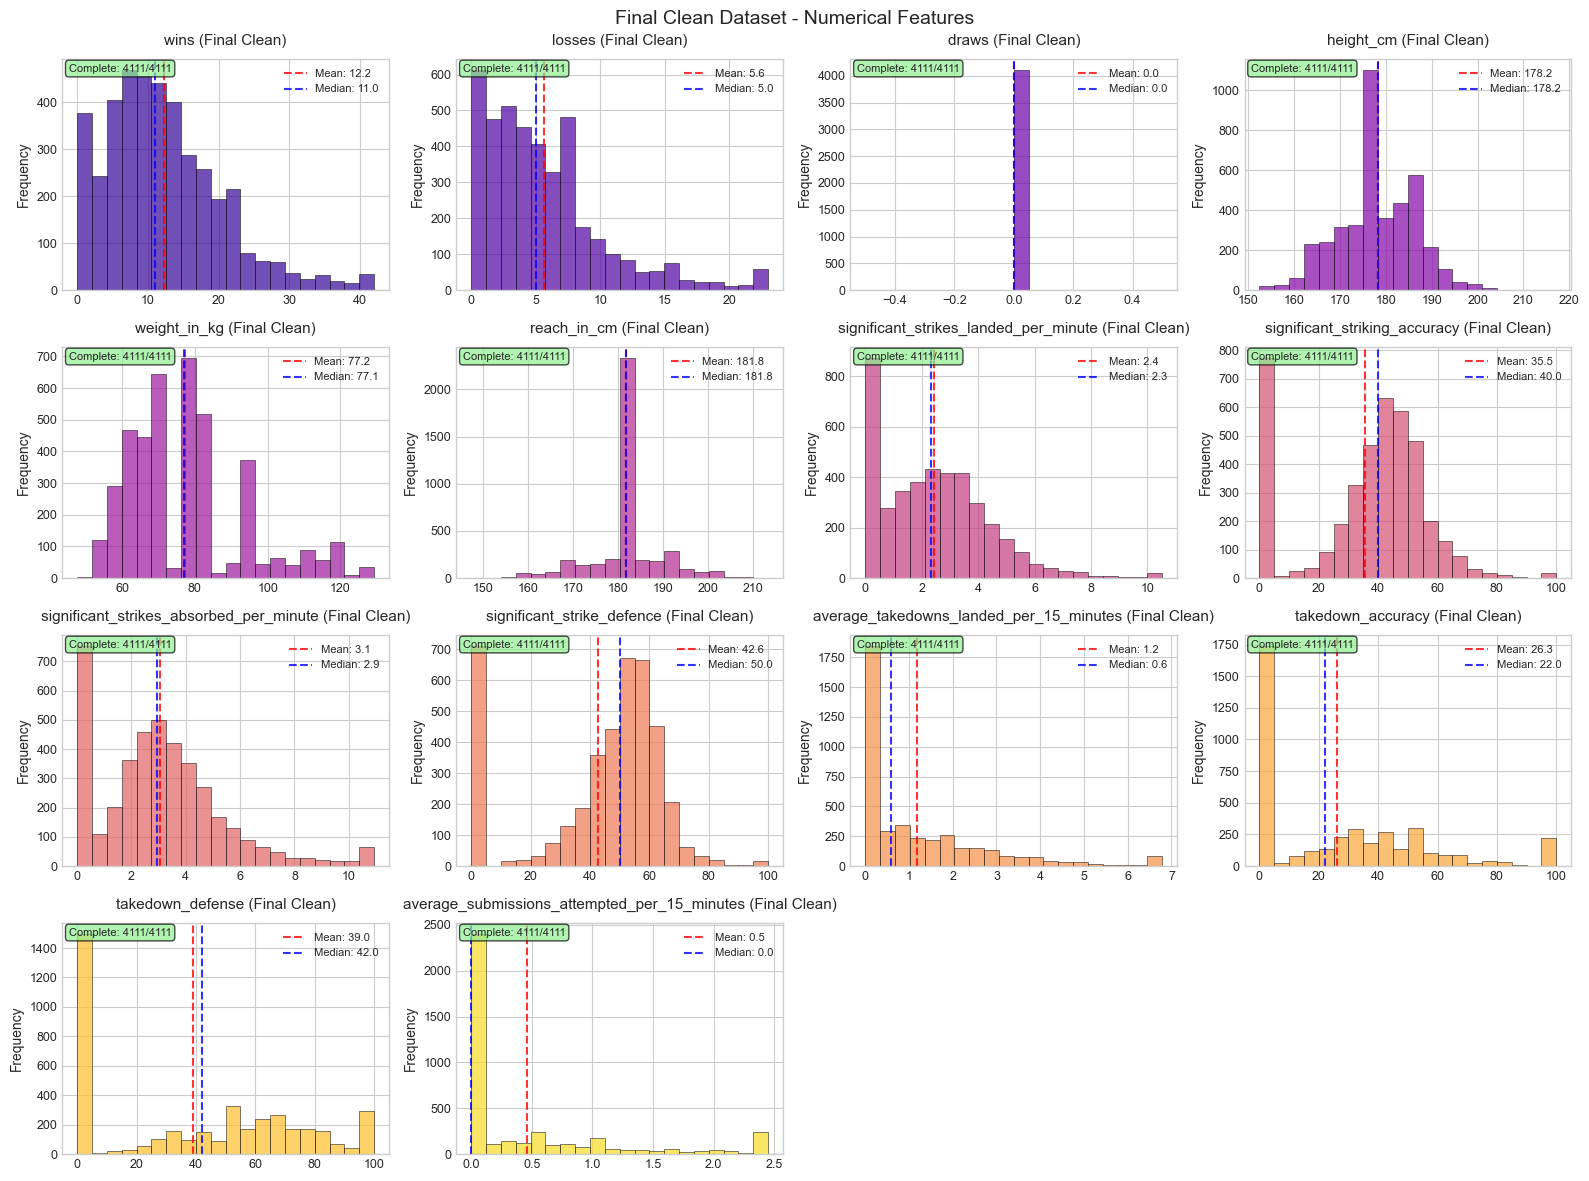

In [43]:
# final clean dataset visualization and summary
print("Distribution after imputation:")

num_cols = column_info['numerical_cols'].drop('G3', errors='ignore')
fig, axes = plot_numerical_distributions(df, num_cols,
                                       title_suffix=" (Final Clean)",
                                       show_missing=False)
plt.suptitle('Final Clean Dataset - Numerical Features', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

In [44]:
print(f"\nFinal dataset summary:")
print(f"Shape: {df.shape[0]} rows x {df.shape[1]} columns")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Categorical columns: {len(column_info['object_cols'])}")
print(f"Numerical columns: {len(column_info['numerical_cols'])}")

# save cleaned dataset
df.to_csv("ufc-fighters-statistics_cleaned.csv", index=False)
print("Saved cleaned dataset to student-mat-cleaned.csv")


Final dataset summary:
Shape: 4111 rows x 18 columns
Missing values: 0
Duplicate rows: 0
Categorical columns: 4
Numerical columns: 14
Saved cleaned dataset to student-mat-cleaned.csv
